# Lecture 9: Posterior Predictive and Gibbs sampling
AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University


In [46]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

import pymc as pm
import time

import random,math
import scipy
import scipy.stats

# Bioassay experiment

This code follows an example from Gelman's "Bayesian Data Analysis".

We demonstrate this with an example and examine the convergence of the resulting samples. 

Bioassay (commonly used shorthand for biological assay), or biological standardisation is a type of scientific experiment. Bioassays are typically conducted to measure the effects of a substance on a living organism and are essential in the development of new drugs and in monitoring environmental pollutants. Both are procedures by which the potency (pharmacology) or the nature of a substance is estimated by studying its effects on living matter.

In this experiment 5 animals were tested for various doses and the number of deaths were recorded. The  death rate is usually modeled as logit$^{-1}$ with two parameters (see below). The goal is to estimate those parameters and be able to infer death rates as a function of dose. 

In [2]:
n=5
X=np.array([-0.86,-0.30,-0.05,0.73])
Y=np.array([0,1,3,5])

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i|\theta_i) = p(y_i, n_i| \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta$ is the rate of deaths which is modeled as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$



# PYMC Version (short)


In [28]:
## invLogit this is the same as a sigmoid
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

alpha = pm.Normal('alpha', mu=0.0, tau=0.01) 
beta = pm.Normal('beta', mu=0.0, tau=0.01)

#alpha = pm.Uniform("alpha", -3., 7.)
#beta = pm.Uniform("beta", -10., 40.)

@pm.deterministic 
def theta(a=alpha, b=beta, x=X):
    return logitInv(a+b*x)

# deaths ~ binomial(n, p), 4 of them
deaths = pm.Binomial('deaths', n=[5,5,5,5], p=theta, value=Y, observed=True)

In [29]:
bioassay_model=pm.Model([alpha, beta, theta, deaths])
mcmc = pm.MCMC(bioassay_model)
mcmc.sample(iter=500000, burn=100000, thin=10)

 [-----------------100%-----------------] 500000 of 500000 complete in 35.6 sec

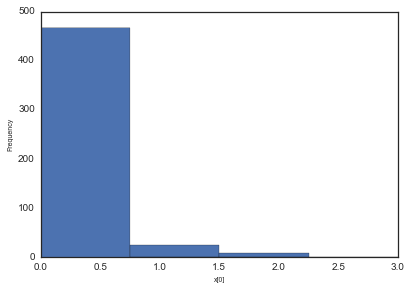

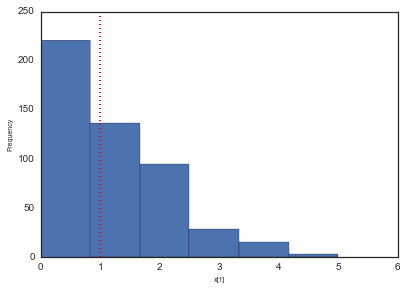

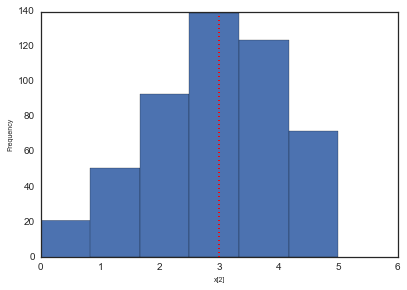

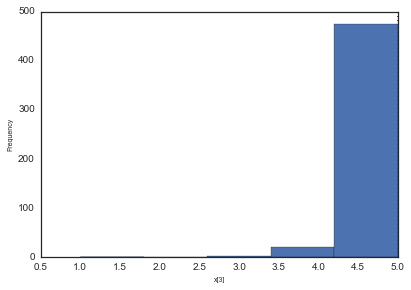

In [54]:
# DIY sampling
# we use the samples we already have for the posterior
# and plug them into our likelihood to sample x

samples = np.zeros((500,4))
for i in xrange(500):
    for j in xrange(4):
        t = theta.trace()[i,j]
        samples[i,j] = scipy.stats.binom.rvs(n=5, p=t)
        
pm.Matplot.gof_plot(samples, Y, name='x')

In [32]:
#posterior predictive
deaths_sim = pm.Binomial('deaths_sim', n=n, p=theta)

In [36]:
posterior_predictive_model = pm.Model([deaths_sim])
mcmc = pm.MCMC(posterior_predictive_model)
mcmc.sample(iter=5000, burn=1000, thin=10)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.7 sec

In [37]:
deaths_sim.trace()

array([[0, 0, 5, 5],
       [0, 1, 5, 5],
       [0, 1, 4, 5],
       ..., 
       [0, 0, 4, 5],
       [0, 0, 5, 5],
       [0, 2, 4, 5]])

[0 1 3 5]


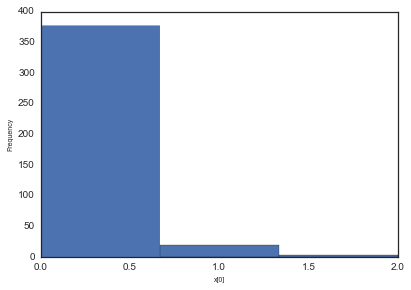

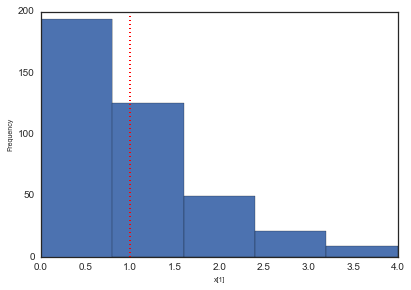

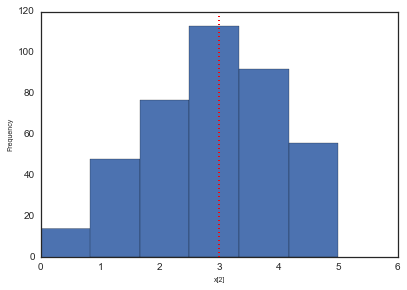

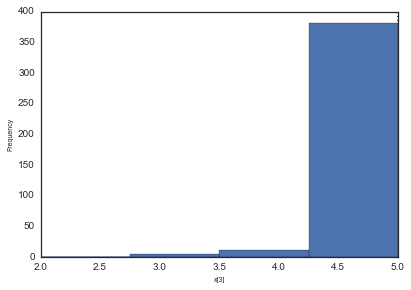

In [39]:
#gof: goodness of fit
pm.Matplot.gof_plot(deaths_sim, Y, name='x')
print Y

# Example: Estimate maize plant weight given bark diameter and plant height.

This very simple dataset is a selection of maize bark diameter ($d$), height ($h$)  with the  weight for each plant ($w$). We wish to estimate a simple linear relationship between these variables, using MCMC.
We model the weight as a function of diameter and height as

$$w_i=β_0+β_1 f(h_i, d_i) + \epsilon$$

$$\epsilon \sim N(0,\sigma_{\epsilon})$$

where $\beta_0$ and $\beta_1$ are the parameters to be estimated, and we are parametrizing the gaussian by its precision $\tau$, which is $1/\sigma_e^2$.

Obviously a good model for that is something that captures the volume: 

$$ f(h_i,d_i) = h_i d_i^2 $$ 

and we rename this quantity as $x_i$, so:

$$w_i=\beta_{0}+\beta_{1} x_i + \epsilon$$ 

and our goal is to estimate the posteriors of $\beta_0$, $\beta_1$ and $\sigma_{\epsilon}$. 

In [58]:
# our data
D=np.array([2.3,1.9,2.2,2,1.7,1.9,2.2,1.9,2.3,2.3,2.1,2.1,2.1,2.2,2,2.1,2.4,1.9,2.7])
H=np.array([176,177,266,264,203,230,220,230,230,245,240,255,210,250,220,240,165,155,185])
W = np.array([735,355,995,750,500,560,910,725,1040,985,895,910,715,1055,720,755,785,555,970])

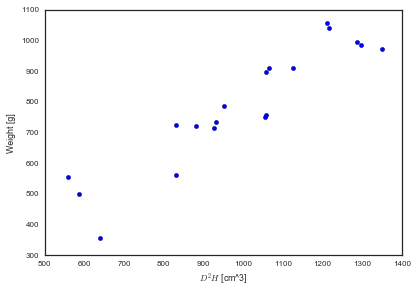

In [59]:
# lets looka t the data
plt.scatter(H*D**2, W)
plt.xlabel('$D^2 H$ [cm^3]')
plt.ylabel('Weight [g]')

In [63]:
# building our model in pymc

beta_0 = pm.Normal('beta_0', mu=0.0, tau=0.001) 
beta_1 = pm.Normal('beta_1', mu=0.0, tau=0.001)
tau = pm.Gamma('tau', alpha=0.001, beta=1000)

@pm.deterministic 
def linear(b_0=beta_0, b_1=beta_1, x=H*D**2):
    return b_0 + b_1 * x

likelihood = pm.Normal('likelihood', linear, tau, value=W, observed=True)


In [64]:
maize_model = pm.Model([beta_0, beta_1, tau, linear, likelihood])
mcmc = pm.MCMC(maize_model)
mcmc.sample(iter=500000, burn=100000, thin=10)

 [-----------------100%-----------------] 500000 of 500000 complete in 42.1 sec

Plotting beta_0
Plotting beta_1
Plotting tau


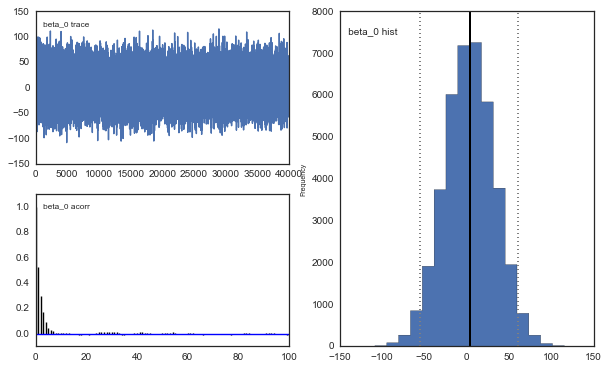

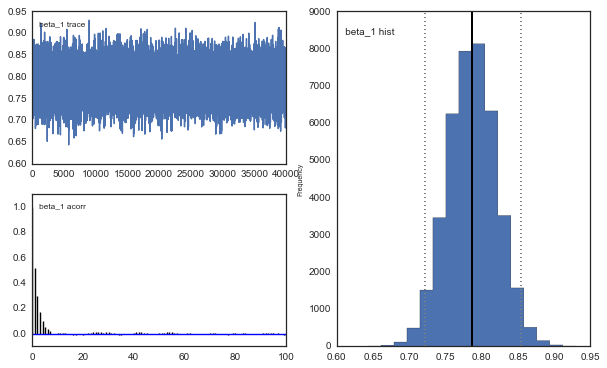

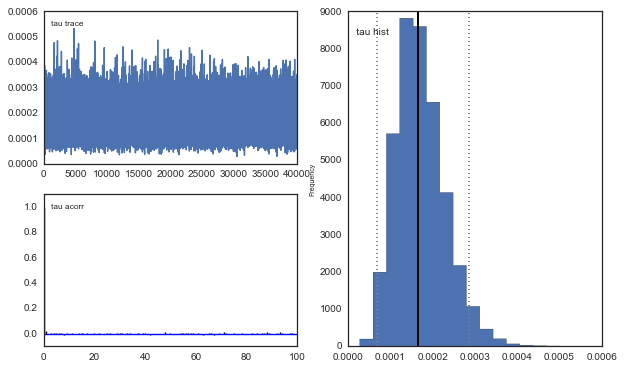

In [68]:
pm.Matplot.plot(beta_0)
pm.Matplot.plot(beta_1)
pm.Matplot.plot(tau)

In [87]:
#posterior predictive
maize_data_sim = pm.Normal('likelihood', linear, tau)

posterior_predictive_model_maize = pm.Model([maize_data_sim])
mcmc = pm.MCMC(posterior_predictive_model_maize)
mcmc.sample(iter=5000, burn=1000, thin=10)

 [-----------------100%-----------------] 5000 of 5000 complete in 1.8 sec

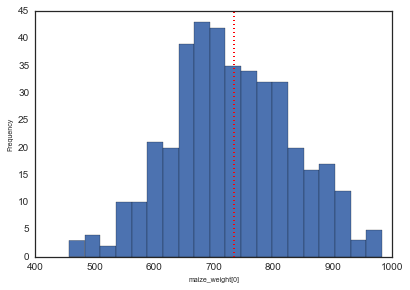

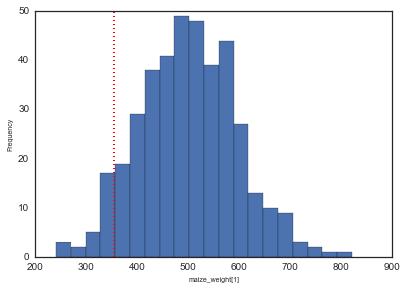

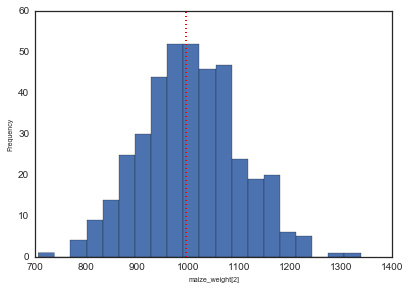

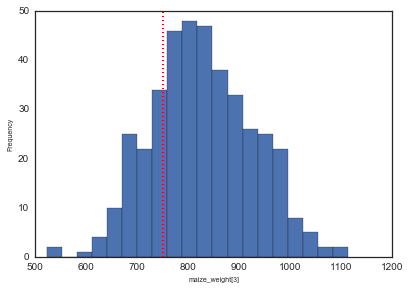

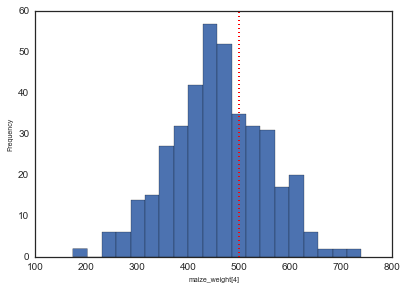

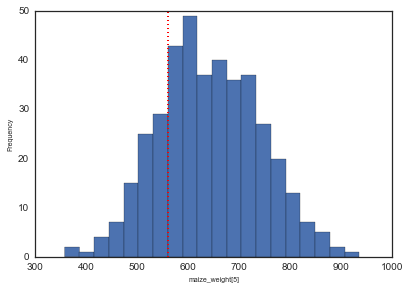

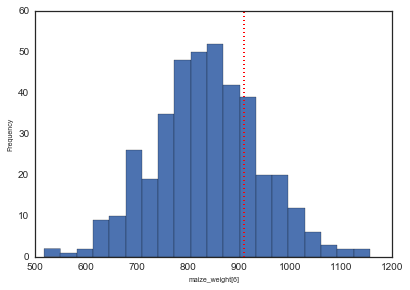

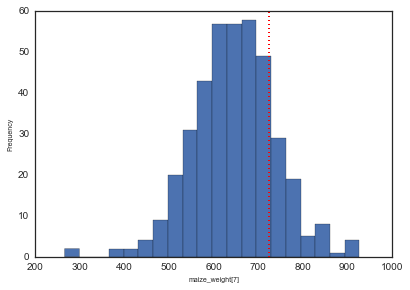

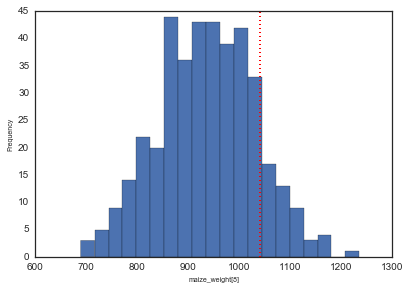

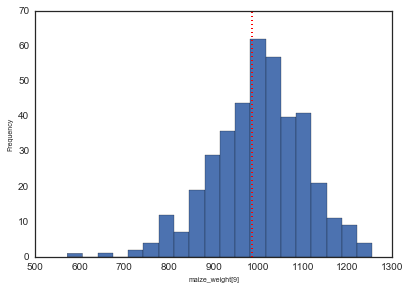

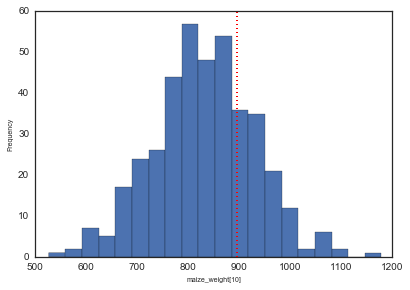

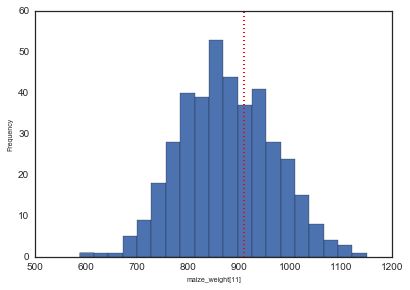

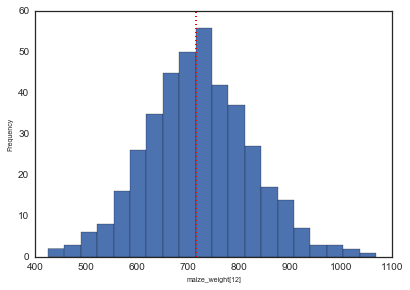

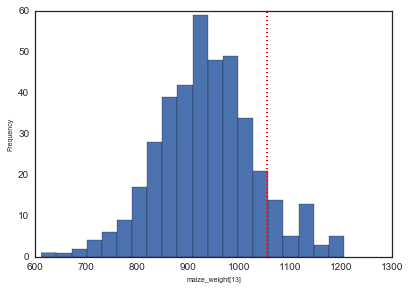

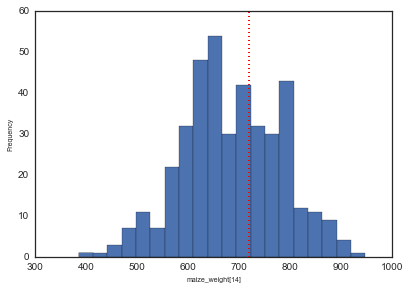

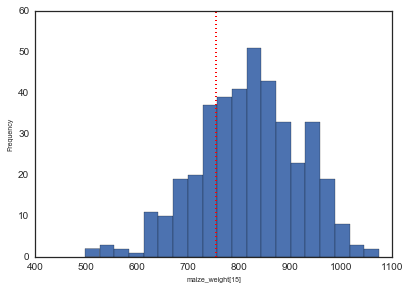

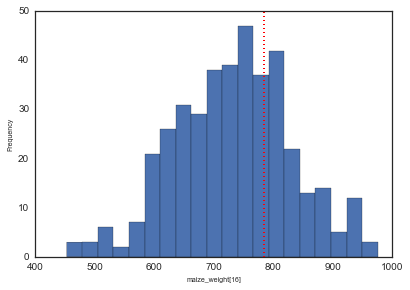

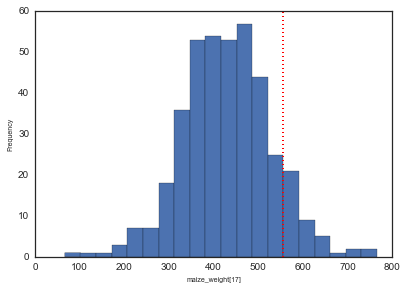

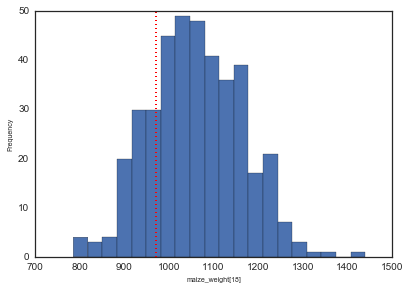

In [73]:
#gof: goodness of fit
pm.Matplot.gof_plot(maize_data_sim, W, name='maize_weight')

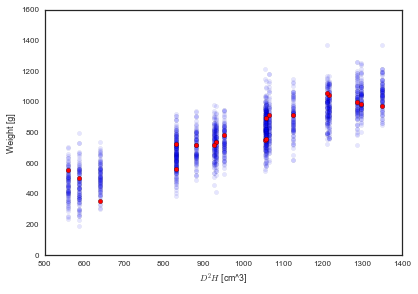

In [88]:
# lets look at the sampled data
for i in xrange(100):
    plt.scatter(H*D**2, maize_data_sim.trace()[i,:], alpha=0.1)
plt.scatter(H*D**2, W, c='r')
plt.xlabel('$D^2 H$ [cm^3]')
plt.ylabel('Weight [g]')

 [-----------------100%-----------------] 5000 of 5000 complete in 2.2 sec

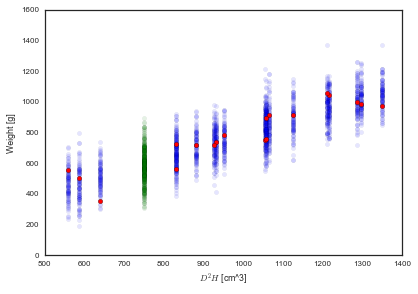

In [90]:
# now for a new previously unseen x
@pm.deterministic 
def linear_750(b_0=beta_0, b_1=beta_1, x=750):
    return b_0 + b_1 * x

maize_data_sim_750 = pm.Normal('likelihood', linear_750, tau)

posterior_predictive_model_maize_750 = pm.Model([maize_data_sim_750])
mcmc = pm.MCMC(posterior_predictive_model_maize_750)
mcmc.sample(iter=5000, burn=1000, thin=10)

# lets looka t the data
for i in xrange(100):
    plt.scatter(H*D**2, maize_data_sim.trace()[i,:], alpha=0.1)
plt.scatter(H*D**2, W, c='r')
plt.scatter([750]*len(maize_data_sim_750.trace()), 
            maize_data_sim_750.trace(), c='g', alpha=0.1)
plt.xlabel('$D^2 H$ [cm^3]')
plt.ylabel('Weight [g]')

In [103]:
# might as well do it for a whole bunch to get a nice plot
x_pp = np.linspace(500,1400,100)

@pm.deterministic 
def linear_x(b_0=beta_0, b_1=beta_1, x=x_pp):
    return b_0 + b_1 * x

maize_data_sim_x = pm.Normal('likelihood', linear_x, tau)

posterior_predictive_model_maize_x = pm.Model([maize_data_sim_x])
mcmc = pm.MCMC(posterior_predictive_model_maize_x)
mcmc.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 5.5 sec

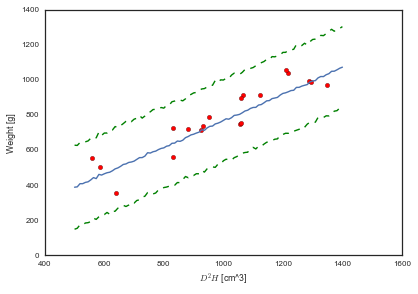

In [104]:
w_pp = np.array(maize_data_sim_x.trace())
# lets looka t the data
plt.scatter(H*D**2, W, c='r')
plt.plot(x_pp, np.mean(w_pp, axis=0))
plt.plot(x_pp, np.mean(w_pp, axis=0)+2*np.std(w_pp, axis=0), '--', c='g')
plt.plot(x_pp, np.mean(w_pp, axis=0)-2*np.std(w_pp, axis=0), '--', c='g')

plt.xlabel('$D^2 H$ [cm^3]')
plt.ylabel('Weight [g]')

# Example Gibbs Sampling

Note: This example is stolen from last years lab section.

<center> $f(x,y) = x^2 {\rm exp}[-xy^2 - y^2 + 2y - 4x]$ </center>

Here's what the distribution really looks like.

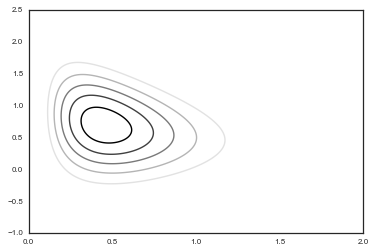

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

func = lambda x,y: x**2*np.exp( -x*y**2 - y**2 + 2*y - 4*x )

foo=400
x = np.linspace(0,2,foo)
y = np.linspace(-1,2.5,foo)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((foo,foo))
for i in np.arange(0,foo):
    for j in np.arange(0,foo):
        zz[i,j]=func(xx[i,j],yy[i,j])
        
plt.contour(xx,yy,zz)

Okay, so it's a pretty distribution, but on first glance the functional form looks terrible and difficult to deal with. But remember from class, a particular power of the Gibbs sampler is that you can directly sample from the conditionals (alternately of course). All we need to do is a little math to construct the functional form of the conditionals and put them in terms of something that we know how to sample from quickly. In the case of our $f(x,y)$ we have:

<center>$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)]{\rm exp}[- y^2 + 2y]$</center> <br><br>
<center>$f(x|y) = x^2 {\rm exp}[-x (y^2 +4)] g(y)$</center> <br><br>
<center>$f(x|y) = g(y){\rm Gamma}(3,y^2+4)$</center>

and...

<center>$f(y|x) = x^2 {\rm exp}[-y^2(1+x) + 2y]{\rm exp}[-4x]$</center> <br><br>
<center>$f(y|x) = x^2 {\rm exp}[-y^2(1+x)] g(x)$</center> <br><br>
<center>$f(y|x) = g(x)N(\frac{1}{1+x},\frac{1}{\sqrt{2(1+x)}})$</center>

So we now invoke our Gibbs sampler to select directly from the functional forms of the conditionals because we know how to sample from a Normal distribution and we know how to sample from a Gamma distribution. In the following code we plan to select a sample of size N=10,000, but we have to conditionally select on the Gamma and Normal distributions 50 thinned times, before we are allowed to select a pair sample each time. 


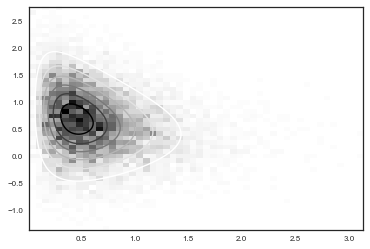

In [43]:
def gibbs(N=10000,thin=500):
    x=0
    y=0
    samples=np.zeros((2,N))
    for i in range(N):
        for j in range(thin):
            # sample
            x=random.gammavariate(3.0, 1.0/(y**2 + 4))
            y=random.gauss(1.0/(x+1), 1.0/np.sqrt(2*(x+1)))
        # accept
        samples[0,i]=x
        samples[1,i]=y
    return samples

out=gibbs()

plt.hist2d(out[0,:],out[1,:], normed=True, bins=50)
plt.contour(xx,yy,zz)
plt.show()